In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional

class HybridRecommender:
    def __init__(self):
        # Weights for different recommendation methods
        self.collab_weight = 0.4
        self.content_weight = 0.3
        self.graph_weight = 0.3

        # Initialize data structures
        self.user_item_matrix = None
        self.item_features = None
        self.user_social_graph = None
        self.item_embeddings = None
        self.item_similarity_matrix = None
        self.user_similarity_matrix = None
        self.item_metadata = {}

        # Item and user mappings (for internal use)
        self.item_id_map = {}
        self.user_id_map = {}
        self.items = []
        self.users = []

    def load_ratings_data(self, ratings_data: List[Dict]) -> None:
        """
        Load user-item ratings data

        Parameters:
        ratings_data (List[Dict]): List of dictionaries with format
                                  {'user_id': str, 'item_id': str, 'rating': float}
        """
        # Create user and item ID mappings
        unique_users = list(set([r['user_id'] for r in ratings_data]))
        unique_items = list(set([r['item_id'] for r in ratings_data]))

        self.users = unique_users
        self.items = unique_items

        self.user_id_map = {user: idx for idx, user in enumerate(unique_users)}
        self.item_id_map = {item: idx for idx, item in enumerate(unique_items)}

        # Create user-item matrix
        self.user_item_matrix = np.zeros((len(unique_users), len(unique_items)))

        for record in ratings_data:
            user_idx = self.user_id_map[record['user_id']]
            item_idx = self.item_id_map[record['item_id']]
            self.user_item_matrix[user_idx, item_idx] = record['rating']

    def load_item_features(self, item_features: List[Dict]) -> None:
        """
        Load item features for content-based filtering

        Parameters:
        item_features (List[Dict]): List of dictionaries with format
                                   {'item_id': str, 'features': str}
        """
        # Store item metadata for display purposes
        for item in item_features:
            self.item_metadata[item['item_id']] = item

        # Create item feature matrix using TF-IDF
        vectorizer = TfidfVectorizer()

        # Ensure items are in the same order as item_id_map
        sorted_features = []
        for item_id in self.items:
            feature_text = next((item['features'] for item in item_features if item['item_id'] == item_id), "")
            sorted_features.append(feature_text)

        self.item_embeddings = vectorizer.fit_transform(sorted_features).toarray()

        # Calculate item-item similarity matrix
        self.item_similarity_matrix = cosine_similarity(self.item_embeddings)

    def load_social_graph(self, connections: List[Dict]) -> None:
        """
        Load social connections between users

        Parameters:
        connections (List[Dict]): List of dictionaries with format
                                 {'user_id': str, 'friend_id': str, 'weight': float}
        """
        # Create a network graph
        G = nx.Graph()

        # Add nodes (users)
        for user in self.users:
            G.add_node(user)

        # Add edges (connections)
        for conn in connections:
            G.add_edge(conn['user_id'], conn['friend_id'], weight=conn['weight'])

        self.user_social_graph = G

        # Calculate user similarity based on graph
        similarity_matrix = np.zeros((len(self.users), len(self.users)))

        for i, user1 in enumerate(self.users):
            for j, user2 in enumerate(self.users):
                if i == j:
                    similarity_matrix[i, j] = 1.0  # Same user
                else:
                    try:
                        # Use shortest path length as a measure of similarity
                        path_length = nx.shortest_path_length(G, user1, user2, weight='weight')
                        # Convert distance to similarity (closer = more similar)
                        similarity_matrix[i, j] = 1.0 / (1.0 + path_length)
                    except nx.NetworkXNoPath:
                        similarity_matrix[i, j] = 0.0  # No path = no similarity

        self.user_similarity_matrix = similarity_matrix

    def _get_collaborative_recommendations(self, user_id: str, top_n: int = 10) -> List[Tuple[str, float]]:
        """
        Get recommendations using collaborative filtering

        Parameters:
        user_id (str): Target user ID
        top_n (int): Number of recommendations to return

        Returns:
        List[Tuple[str, float]]: List of (item_id, score) tuples
        """
        if user_id not in self.user_id_map:
            return []

        user_idx = self.user_id_map[user_id]

        # Use user-user similarity to predict ratings
        user_ratings = self.user_item_matrix[user_idx]

        # Items already rated by the user
        rated_items = set(np.where(user_ratings > 0)[0])

        # Predict ratings for unrated items
        predictions = []

        for item_idx in range(len(self.items)):
            if item_idx in rated_items:
                continue

            # Calculate weighted average rating using similar users
            numerator = 0
            denominator = 0

            for other_user_idx in range(len(self.users)):
                if other_user_idx == user_idx:
                    continue

                # Skip if other user hasn't rated this item
                if self.user_item_matrix[other_user_idx, item_idx] == 0:
                    continue

                similarity = self.user_similarity_matrix[user_idx, other_user_idx]
                rating = self.user_item_matrix[other_user_idx, item_idx]

                numerator += similarity * rating
                denominator += similarity

            if denominator > 0:
                predicted_rating = numerator / denominator
                item_id = self.items[item_idx]
                predictions.append((item_id, predicted_rating))

        # Sort by predicted rating (descending)
        predictions.sort(key=lambda x: x[1], reverse=True)

        return predictions[:top_n]

    def _get_content_recommendations(self, user_id: str, top_n: int = 10) -> List[Tuple[str, float]]:
        """
        Get recommendations using content-based filtering

        Parameters:
        user_id (str): Target user ID
        top_n (int): Number of recommendations to return

        Returns:
        List[Tuple[str, float]]: List of (item_id, score) tuples
        """
        if user_id not in self.user_id_map:
            return []

        user_idx = self.user_id_map[user_id]

        # Get user's rating profile
        user_ratings = self.user_item_matrix[user_idx]

        # Items already rated by the user
        rated_items = np.where(user_ratings > 0)[0]
        rated_item_scores = user_ratings[rated_items]

        if len(rated_items) == 0:
            return []  # Can't make content recommendations without any ratings

        # Calculate user profile as weighted average of item features
        user_profile = np.zeros(self.item_embeddings.shape[1])

        for i, item_idx in enumerate(rated_items):
            user_profile += rated_item_scores[i] * self.item_embeddings[item_idx]

        if np.sum(user_profile) > 0:
            user_profile = user_profile / np.sum(user_profile)

        # Calculate similarity between user profile and all items
        scores = []

        for item_idx in range(len(self.items)):
            if user_ratings[item_idx] > 0:
                continue  # Skip already rated items

            item_features = self.item_embeddings[item_idx]

            # Calculate cosine similarity
            similarity = np.dot(user_profile, item_features) / (
                np.linalg.norm(user_profile) * np.linalg.norm(item_features) + 1e-8
            )

            item_id = self.items[item_idx]
            scores.append((item_id, similarity))

        # Sort by similarity (descending)
        scores.sort(key=lambda x: x[1], reverse=True)

        return scores[:top_n]

    def _get_graph_recommendations(self, user_id: str, top_n: int = 10) -> List[Tuple[str, float]]:
        """
        Get recommendations using graph-based approach

        Parameters:
        user_id (str): Target user ID
        top_n (int): Number of recommendations to return

        Returns:
        List[Tuple[str, float]]: List of (item_id, score) tuples
        """
        if user_id not in self.user_id_map or self.user_social_graph is None:
            return []

        user_idx = self.user_id_map[user_id]

        # Get user's friends
        friends = [neighbor for neighbor in self.user_social_graph.neighbors(user_id)]

        if not friends:
            return []

        # Items already rated by the user
        user_ratings = self.user_item_matrix[user_idx]
        rated_items = set(np.where(user_ratings > 0)[0])

        # Collect recommendations from friends
        friend_recs = {}

        for friend in friends:
            if friend not in self.user_id_map:
                continue

            friend_idx = self.user_id_map[friend]
            friend_ratings = self.user_item_matrix[friend_idx]

            # Get edge weight (friendship strength)
            edge_data = self.user_social_graph.get_edge_data(user_id, friend)
            weight = edge_data.get('weight', 1.0) if edge_data else 1.0

            for item_idx in range(len(self.items)):
                if item_idx in rated_items:
                    continue

                if friend_ratings[item_idx] > 0:
                    item_id = self.items[item_idx]
                    score = friend_ratings[item_idx] * weight

                    if item_id in friend_recs:
                        friend_recs[item_id] += score
                    else:
                        friend_recs[item_id] = score

        # Convert to list and sort
        recommendations = [(item_id, score) for item_id, score in friend_recs.items()]
        recommendations.sort(key=lambda x: x[1], reverse=True)

        return recommendations[:top_n]

    def get_recommendations(self, user_id: str, top_n: int = 10) -> List[Dict]:
        """
        Get hybrid recommendations

        Parameters:
        user_id (str): Target user ID
        top_n (int): Number of recommendations to return

        Returns:
        List[Dict]: List of recommendations with details
        """
        # Get recommendations from each approach
        collab_recs = self._get_collaborative_recommendations(user_id, top_n=top_n*2)
        content_recs = self._get_content_recommendations(user_id, top_n=top_n*2)
        graph_recs = self._get_graph_recommendations(user_id, top_n=top_n*2)

        # Combine recommendations
        item_scores = {}

        # Add collaborative filtering scores
        for item_id, score in collab_recs:
            item_scores[item_id] = self.collab_weight * score

        # Add content-based scores
        for item_id, score in content_recs:
            if item_id in item_scores:
                item_scores[item_id] += self.content_weight * score
            else:
                item_scores[item_id] = self.content_weight * score

        # Add graph-based scores
        for item_id, score in graph_recs:
            if item_id in item_scores:
                item_scores[item_id] += self.graph_weight * score
            else:
                item_scores[item_id] = self.graph_weight * score

        # Sort by final score
        final_recs = [(item_id, score) for item_id, score in item_scores.items()]
        final_recs.sort(key=lambda x: x[1], reverse=True)

        # Format results
        results = []
        for item_id, score in final_recs[:top_n]:
            # Get item metadata
            metadata = self.item_metadata.get(item_id, {})

            # Add source information
            sources = []
            if item_id in [i[0] for i in collab_recs]:
                sources.append("collaborative")
            if item_id in [i[0] for i in content_recs]:
                sources.append("content-based")
            if item_id in [i[0] for i in graph_recs]:
                sources.append("graph-based")

            rec = {
                "item_id": item_id,
                "score": score,
                "title": metadata.get("title", "Unknown"),
                "features": metadata.get("features", ""),
                "recommendation_sources": sources
            }
            results.append(rec)

        return results

    def visualize_graph(self, highlight_user=None):
        """
        Visualize the user social graph

        Parameters:
        highlight_user (str): User to highlight in the graph
        """
        if self.user_social_graph is None:
            print("No social graph data loaded")
            return

        plt.figure(figsize=(10, 8))

        pos = nx.spring_layout(self.user_social_graph)

        # Draw the graph
        nx.draw(self.user_social_graph, pos, with_labels=True, node_color='lightblue',
                node_size=500, edge_color='gray', linewidths=1, font_size=10)

        # Highlight specific user if provided
        if highlight_user and highlight_user in self.user_social_graph:
            nx.draw_networkx_nodes(self.user_social_graph, pos,
                                  nodelist=[highlight_user],
                                  node_color='red',
                                  node_size=700)

        plt.title("User Social Graph")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def explain_recommendation(self, user_id: str, item_id: str) -> Dict:
        """
        Explain why an item was recommended to a user

        Parameters:
        user_id (str): Target user ID
        item_id (str): Recommended item ID

        Returns:
        Dict: Explanation with contribution from each approach
        """
        if user_id not in self.user_id_map or item_id not in self.item_id_map:
            return {"error": "User or item not found"}

        user_idx = self.user_id_map[user_id]
        item_idx = self.item_id_map[item_id]

        # Check if user has already rated this item
        if self.user_item_matrix[user_idx, item_idx] > 0:
            return {"error": "User has already rated this item"}

        # Get contribution from collaborative filtering
        collab_score = 0
        for other_user_idx in range(len(self.users)):
            if other_user_idx == user_idx:
                continue

            if self.user_item_matrix[other_user_idx, item_idx] > 0:
                similarity = self.user_similarity_matrix[user_idx, other_user_idx]
                rating = self.user_item_matrix[other_user_idx, item_idx]
                collab_score += similarity * rating

        # Get contribution from content-based filtering
        content_score = 0
        user_ratings = self.user_item_matrix[user_idx]
        rated_items = np.where(user_ratings > 0)[0]

        if len(rated_items) > 0:
            user_profile = np.zeros(self.item_embeddings.shape[1])
            for rated_item_idx in rated_items:
                user_profile += user_ratings[rated_item_idx] * self.item_embeddings[rated_item_idx]

            if np.sum(user_profile) > 0:
                user_profile = user_profile / np.sum(user_profile)

            item_features = self.item_embeddings[item_idx]

            # Calculate similarity between user profile and this item
            content_score = np.dot(user_profile, item_features) / (
                np.linalg.norm(user_profile) * np.linalg.norm(item_features) + 1e-8
            )

        # Get contribution from graph-based approach
        graph_score = 0
        if self.user_social_graph is not None:
            friends = [neighbor for neighbor in self.user_social_graph.neighbors(user_id)]

            for friend in friends:
                if friend not in self.user_id_map:
                    continue

                friend_idx = self.user_id_map[friend]

                if self.user_item_matrix[friend_idx, item_idx] > 0:
                    edge_data = self.user_social_graph.get_edge_data(user_id, friend)
                    weight = edge_data.get('weight', 1.0) if edge_data else 1.0
                    graph_score += self.user_item_matrix[friend_idx, item_idx] * weight

        # Calculate total score
        total_score = (
            self.collab_weight * collab_score +
            self.content_weight * content_score +
            self.graph_weight * graph_score
        )

        # Calculate percentage contribution
        if total_score > 0:
            collab_contrib = (self.collab_weight * collab_score / total_score) * 100
            content_contrib = (self.content_weight * content_score / total_score) * 100
            graph_contrib = (self.graph_weight * graph_score / total_score) * 100
        else:
            collab_contrib = content_contrib = graph_contrib = 0

        # Get similar items (for content-based explanation)
        similar_items = []
        for i in rated_items:
            similarity = self.item_similarity_matrix[item_idx, i]
            if similarity > 0.2:  # Threshold for similarity
                similar_items.append({
                    "item_id": self.items[i],
                    "title": self.item_metadata.get(self.items[i], {}).get("title", "Unknown"),
                    "similarity": similarity,
                    "user_rating": self.user_item_matrix[user_idx, i]
                })

        similar_items.sort(key=lambda x: x["similarity"], reverse=True)

        # Get similar users (for collaborative explanation)
        similar_users = []
        for i in range(len(self.users)):
            if i == user_idx:
                continue

            similarity = self.user_similarity_matrix[user_idx, i]
            if similarity > 0.2 and self.user_item_matrix[i, item_idx] > 0:
                similar_users.append({
                    "user_id": self.users[i],
                    "similarity": similarity,
                    "rating": self.user_item_matrix[i, item_idx]
                })

        similar_users.sort(key=lambda x: x["similarity"], reverse=True)

        # Get friends who rated this item (for graph explanation)
        friends_ratings = []
        if self.user_social_graph is not None:
            for friend in friends:
                if friend in self.user_id_map:
                    friend_idx = self.user_id_map[friend]

                    if self.user_item_matrix[friend_idx, item_idx] > 0:
                        edge_data = self.user_social_graph.get_edge_data(user_id, friend)
                        weight = edge_data.get('weight', 1.0) if edge_data else 1.0

                        friends_ratings.append({
                            "user_id": friend,
                            "rating": self.user_item_matrix[friend_idx, item_idx],
                            "connection_strength": weight
                        })

        friends_ratings.sort(key=lambda x: x["connection_strength"], reverse=True)

        # Create explanation
        explanation = {
            "item_id": item_id,
            "title": self.item_metadata.get(item_id, {}).get("title", "Unknown"),
            "features": self.item_metadata.get(item_id, {}).get("features", ""),
            "total_score": total_score,
            "score_breakdown": {
                "collaborative": {
                    "raw_score": collab_score,
                    "weighted_score": self.collab_weight * collab_score,
                    "contribution_percentage": collab_contrib,
                    "similar_users": similar_users[:3]  # Top 3 similar users
                },
                "content_based": {
                    "raw_score": content_score,
                    "weighted_score": self.content_weight * content_score,
                    "contribution_percentage": content_contrib,
                    "similar_items_you_liked": similar_items[:3]  # Top 3 similar items
                },
                "graph_based": {
                    "raw_score": graph_score,
                    "weighted_score": self.graph_weight * graph_score,
                    "contribution_percentage": graph_contrib,
                    "friends_who_liked_this": friends_ratings[:3]  # Top 3 friends
                }
            }
        }

        return explanation


# Example Usage
def run_example():
    # Create sample data

    # 1. Sample users and items
    users = ["user1", "user2", "user3", "user4", "user5"]
    items = ["movie1", "movie2", "movie3", "movie4", "movie5", "movie6", "movie7", "movie8"]

    # 2. Sample user-item ratings
    ratings_data = [
        {"user_id": "user1", "item_id": "movie1", "rating": 5.0},
        {"user_id": "user1", "item_id": "movie2", "rating": 4.0},
        {"user_id": "user1", "item_id": "movie3", "rating": 2.5},
        {"user_id": "user2", "item_id": "movie1", "rating": 4.5},
        {"user_id": "user2", "item_id": "movie4", "rating": 4.0},
        {"user_id": "user2", "item_id": "movie5", "rating": 3.5},
        {"user_id": "user3", "item_id": "movie2", "rating": 4.0},
        {"user_id": "user3", "item_id": "movie4", "rating": 5.0},
        {"user_id": "user3", "item_id": "movie6", "rating": 4.5},
        {"user_id": "user4", "item_id": "movie1", "rating": 3.5},
        {"user_id": "user4", "item_id": "movie3", "rating": 4.0},
        {"user_id": "user4", "item_id": "movie5", "rating": 3.0},
        {"user_id": "user4", "item_id": "movie7", "rating": 4.5},
        {"user_id": "user5", "item_id": "movie2", "rating": 3.5},
        {"user_id": "user5", "item_id": "movie6", "rating": 4.0},
        {"user_id": "user5", "item_id": "movie8", "rating": 5.0},
    ]

    # 3. Sample item features
    item_features = [
        {"item_id": "movie1", "title": "The Matrix", "features": "sci-fi action cyberpunk dystopian future AI"},
        {"item_id": "movie2", "title": "Inception", "features": "sci-fi thriller psychological dreams mind-bending"},
        {"item_id": "movie3", "title": "The Godfather", "features": "crime drama mafia family power"},
        {"item_id": "movie4", "title": "Interstellar", "features": "sci-fi space exploration future time travel"},
        {"item_id": "movie5", "title": "The Dark Knight", "features": "superhero action crime thriller"},
        {"item_id": "movie6", "title": "Blade Runner 2049", "features": "sci-fi dystopian future AI cyberpunk"},
        {"item_id": "movie7", "title": "Pulp Fiction", "features": "crime drama non-linear storytelling"},
        {"item_id": "movie8", "title": "Avatar", "features": "sci-fi action adventure space aliens nature"}
    ]

    # 4. Sample social connections
    social_connections = [
        {"user_id": "user1", "friend_id": "user2", "weight": 0.8},
        {"user_id": "user1", "friend_id": "user4", "weight": 0.6},
        {"user_id": "user2", "friend_id": "user3", "weight": 0.9},
        {"user_id": "user2", "friend_id": "user5", "weight": 0.5},
        {"user_id": "user3", "friend_id": "user5", "weight": 0.7},
        {"user_id": "user4", "friend_id": "user5", "weight": 0.6}
    ]

    # Create and initialize the recommender
    recommender = HybridRecommender()
    recommender.load_ratings_data(ratings_data)
    recommender.load_item_features(item_features)
    recommender.load_social_graph(social_connections)

    # Get recommendations for a user
    user_to_recommend = "user1"
    recommendations = recommender.get_recommendations(user_to_recommend, top_n=3)

    print(f"\nRecommendations for {user_to_recommend}:")
    print("-" * 50)
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec['title']} (ID: {rec['item_id']})")
        print(f"   Score: {rec['score']:.4f}")
        print(f"   Features: {rec['features']}")
        print(f"   Sources: {', '.join(rec['recommendation_sources'])}")
        print()

    # Explain a specific recommendation
    if recommendations:
        explained_item = recommendations[0]['item_id']
        explanation = recommender.explain_recommendation(user_to_recommend, explained_item)

        print(f"\nExplanation for recommending '{explanation['title']}' to {user_to_recommend}:")
        print("-" * 50)
        print(f"Total Score: {explanation['total_score']:.4f}")
        print("\nScore Breakdown:")

        for method, details in explanation['score_breakdown'].items():
            print(f"\n{method.replace('_', ' ').title()} ({details['contribution_percentage']:.1f}%):")
            print(f"Raw Score: {details['raw_score']:.4f}")
            print(f"Weighted Score: {details['weighted_score']:.4f}")

            if method == "collaborative" and details['similar_users']:
                print("\nSimilar users who liked this:")
                for user in details['similar_users']:
                    print(f"- {user['user_id']} (similarity: {user['similarity']:.2f}, rating: {user['rating']:.1f})")

            elif method == "content_based" and details['similar_items_you_liked']:
                print("\nSimilar items you liked:")
                for item in details['similar_items_you_liked']:
                    print(f"- {item['title']} (similarity: {item['similarity']:.2f}, you rated: {item['user_rating']:.1f})")

            elif method == "graph_based" and details['friends_who_liked_this']:
                print("\nFriends who liked this:")
                for friend in details['friends_who_liked_this']:
                    print(f"- {friend['user_id']} (connection: {friend['connection_strength']:.2f}, rating: {friend['rating']:.1f})")

    # Test with a custom input
    custom_user = input("\nEnter a user ID to get recommendations (user1-user5): ")
    if custom_user in users:
        custom_recs = recommender.get_recommendations(custom_user, top_n=3)

        print(f"\nRecommendations for {custom_user}:")
        print("-" * 50)
        for i, rec in enumerate(custom_recs, 1):
            print(f"{i}. {rec['title']} (ID: {rec['item_id']})")
            print(f"   Score: {rec['score']:.4f}")
            print(f"   Features: {rec['features']}")
            print(f"   Sources: {', '.join(rec['recommendation_sources'])}")
            print()
    else:
        print(f"User {custom_user} not found. Please try again with a valid user ID.")

if __name__ == "__main__":
    run_example()


Recommendations for user1:
--------------------------------------------------
1. Interstellar (ID: movie4)
   Score: 2.7959
   Features: sci-fi space exploration future time travel
   Sources: collaborative, content-based, graph-based

2. The Dark Knight (ID: movie5)
   Score: 2.7537
   Features: superhero action crime thriller
   Sources: collaborative, content-based, graph-based

3. Pulp Fiction (ID: movie7)
   Score: 2.6399
   Features: crime drama non-linear storytelling
   Sources: collaborative, content-based, graph-based


Explanation for recommending 'Interstellar' to user1:
--------------------------------------------------
Total Score: 2.6656

Score Breakdown:

Collaborative (61.1%):
Raw Score: 4.0741
Weighted Score: 1.6296

Similar users who liked this:
- user2 (similarity: 0.56, rating: 4.0)
- user3 (similarity: 0.37, rating: 5.0)

Content Based (2.8%):
Raw Score: 0.2531
Weighted Score: 0.0759

Similar items you liked:
- The Matrix (similarity: 0.27, you rated: 5.0)

Graph

In [2]:
recommender = HybridRecommender()


Recommendations for user1:
--------------------------------------------------
1. Fight Club (ID: movie11)
   Score: 3.6769
   Features: drama thriller psychological twist identity consumerism
   Sources: collaborative, content-based, graph-based

2. Pulp Fiction (ID: movie7)
   Score: 3.2510
   Features: crime drama non-linear storytelling tarantino violence
   Sources: collaborative, graph-based

3. The Shawshank Redemption (ID: movie9)
   Score: 2.8486
   Features: drama prison friendship hope redemption escape
   Sources: collaborative, graph-based

4. The Revenant (ID: movie25)
   Score: 2.6767
   Features: adventure drama survival wilderness revenge bear
   Sources: collaborative, graph-based

5. The Avengers (ID: movie18)
   Score: 1.9947
   Features: superhero action adventure team marvel aliens
   Sources: collaborative, content-based


Explanation for recommending 'Fight Club' to user1:
--------------------------------------------------
Total Score: 4.9008

Score Breakdown:



<ipython-input-1-25a1daf6bfb1>:391: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


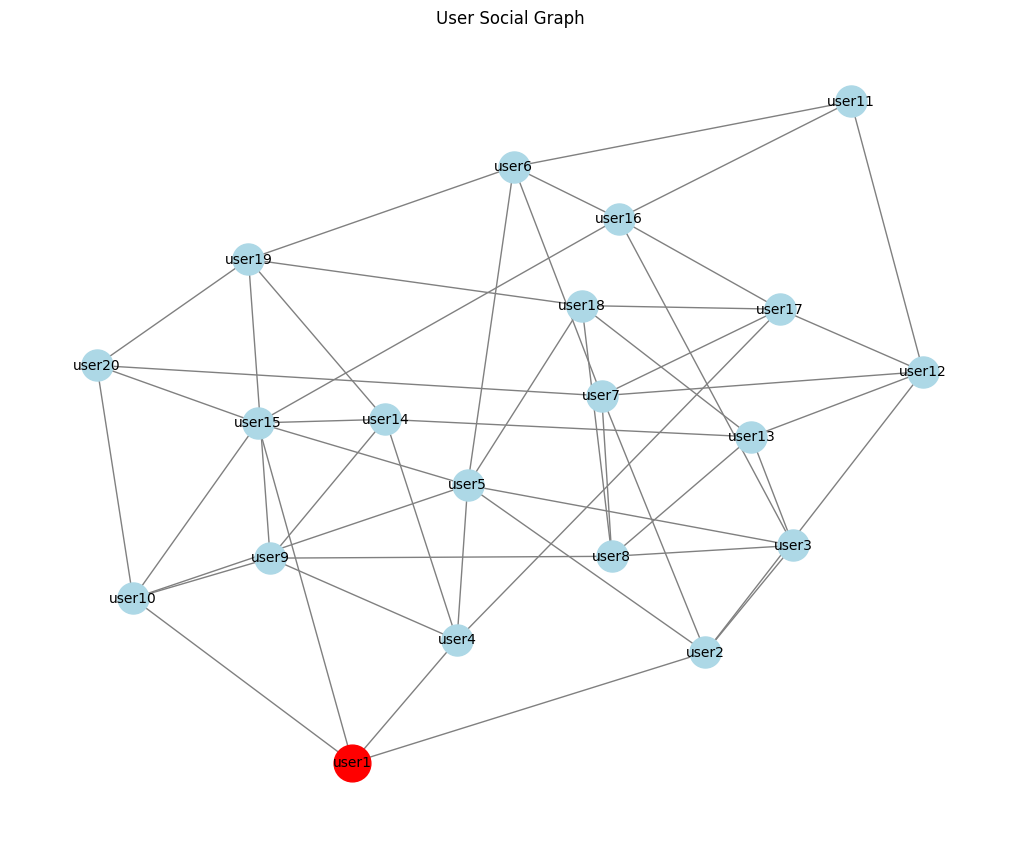

In [3]:
def run_expanded_example():
    # Create expanded sample data

    # 1. Sample users and items
    users = [f"user{i}" for i in range(1, 21)]  # 20 users
    items = [f"movie{i}" for i in range(1, 31)]  # 30 movies

    # 2. Sample user-item ratings (expanded)
    ratings_data = [
        # User 1
        {"user_id": "user1", "item_id": "movie1", "rating": 5.0},
        {"user_id": "user1", "item_id": "movie2", "rating": 4.0},
        {"user_id": "user1", "item_id": "movie3", "rating": 2.5},
        {"user_id": "user1", "item_id": "movie8", "rating": 4.2},
        {"user_id": "user1", "item_id": "movie12", "rating": 3.7},

        # User 2
        {"user_id": "user2", "item_id": "movie1", "rating": 4.5},
        {"user_id": "user2", "item_id": "movie4", "rating": 4.0},
        {"user_id": "user2", "item_id": "movie5", "rating": 3.5},
        {"user_id": "user2", "item_id": "movie9", "rating": 4.8},
        {"user_id": "user2", "item_id": "movie15", "rating": 2.3},

        # User 3
        {"user_id": "user3", "item_id": "movie2", "rating": 4.0},
        {"user_id": "user3", "item_id": "movie4", "rating": 5.0},
        {"user_id": "user3", "item_id": "movie6", "rating": 4.5},
        {"user_id": "user3", "item_id": "movie10", "rating": 3.9},
        {"user_id": "user3", "item_id": "movie14", "rating": 4.2},

        # User 4
        {"user_id": "user4", "item_id": "movie1", "rating": 3.5},
        {"user_id": "user4", "item_id": "movie3", "rating": 4.0},
        {"user_id": "user4", "item_id": "movie5", "rating": 3.0},
        {"user_id": "user4", "item_id": "movie7", "rating": 4.5},
        {"user_id": "user4", "item_id": "movie11", "rating": 5.0},

        # User 5
        {"user_id": "user5", "item_id": "movie2", "rating": 3.5},
        {"user_id": "user5", "item_id": "movie6", "rating": 4.0},
        {"user_id": "user5", "item_id": "movie8", "rating": 5.0},
        {"user_id": "user5", "item_id": "movie13", "rating": 3.8},
        {"user_id": "user5", "item_id": "movie16", "rating": 4.1},

        # User 6
        {"user_id": "user6", "item_id": "movie3", "rating": 4.2},
        {"user_id": "user6", "item_id": "movie7", "rating": 3.9},
        {"user_id": "user6", "item_id": "movie12", "rating": 4.7},
        {"user_id": "user6", "item_id": "movie17", "rating": 3.5},
        {"user_id": "user6", "item_id": "movie21", "rating": 4.0},

        # User 7
        {"user_id": "user7", "item_id": "movie4", "rating": 3.8},
        {"user_id": "user7", "item_id": "movie8", "rating": 4.3},
        {"user_id": "user7", "item_id": "movie13", "rating": 3.7},
        {"user_id": "user7", "item_id": "movie18", "rating": 4.9},
        {"user_id": "user7", "item_id": "movie22", "rating": 3.4},

        # User 8
        {"user_id": "user8", "item_id": "movie5", "rating": 4.1},
        {"user_id": "user8", "item_id": "movie9", "rating": 3.6},
        {"user_id": "user8", "item_id": "movie14", "rating": 4.5},
        {"user_id": "user8", "item_id": "movie19", "rating": 3.2},
        {"user_id": "user8", "item_id": "movie23", "rating": 4.8},

        # User 9
        {"user_id": "user9", "item_id": "movie6", "rating": 3.9},
        {"user_id": "user9", "item_id": "movie10", "rating": 4.4},
        {"user_id": "user9", "item_id": "movie15", "rating": 3.3},
        {"user_id": "user9", "item_id": "movie20", "rating": 4.7},
        {"user_id": "user9", "item_id": "movie24", "rating": 3.5},

        # User 10
        {"user_id": "user10", "item_id": "movie1", "rating": 4.2},
        {"user_id": "user10", "item_id": "movie7", "rating": 3.7},
        {"user_id": "user10", "item_id": "movie11", "rating": 4.6},
        {"user_id": "user10", "item_id": "movie16", "rating": 3.4},
        {"user_id": "user10", "item_id": "movie25", "rating": 4.3},

        # Users 11-20 (fewer ratings per user)
        {"user_id": "user11", "item_id": "movie2", "rating": 3.8},
        {"user_id": "user11", "item_id": "movie12", "rating": 4.1},
        {"user_id": "user11", "item_id": "movie22", "rating": 3.6},

        {"user_id": "user12", "item_id": "movie3", "rating": 4.3},
        {"user_id": "user12", "item_id": "movie13", "rating": 3.2},
        {"user_id": "user12", "item_id": "movie23", "rating": 4.5},

        {"user_id": "user13", "item_id": "movie4", "rating": 3.9},
        {"user_id": "user13", "item_id": "movie14", "rating": 4.7},
        {"user_id": "user13", "item_id": "movie24", "rating": 3.4},

        {"user_id": "user14", "item_id": "movie5", "rating": 4.4},
        {"user_id": "user14", "item_id": "movie15", "rating": 3.1},
        {"user_id": "user14", "item_id": "movie25", "rating": 4.6},

        {"user_id": "user15", "item_id": "movie6", "rating": 3.7},
        {"user_id": "user15", "item_id": "movie16", "rating": 4.2},
        {"user_id": "user15", "item_id": "movie26", "rating": 3.8},

        {"user_id": "user16", "item_id": "movie7", "rating": 4.5},
        {"user_id": "user16", "item_id": "movie17", "rating": 3.3},
        {"user_id": "user16", "item_id": "movie27", "rating": 4.1},

        {"user_id": "user17", "item_id": "movie8", "rating": 3.6},
        {"user_id": "user17", "item_id": "movie18", "rating": 4.8},
        {"user_id": "user17", "item_id": "movie28", "rating": 3.5},

        {"user_id": "user18", "item_id": "movie9", "rating": 4.0},
        {"user_id": "user18", "item_id": "movie19", "rating": 3.9},
        {"user_id": "user18", "item_id": "movie29", "rating": 4.3},

        {"user_id": "user19", "item_id": "movie10", "rating": 3.4},
        {"user_id": "user19", "item_id": "movie20", "rating": 4.6},
        {"user_id": "user19", "item_id": "movie30", "rating": 3.7},

        {"user_id": "user20", "item_id": "movie1", "rating": 4.2},
        {"user_id": "user20", "item_id": "movie11", "rating": 3.5},
        {"user_id": "user20", "item_id": "movie21", "rating": 4.4},
    ]

    # 3. Sample item features (expanded)
    item_features = [
        {"item_id": "movie1", "title": "The Matrix", "features": "sci-fi action cyberpunk dystopian future AI virtual-reality"},
        {"item_id": "movie2", "title": "Inception", "features": "sci-fi thriller psychological dreams mind-bending heist"},
        {"item_id": "movie3", "title": "The Godfather", "features": "crime drama mafia family power revenge classic"},
        {"item_id": "movie4", "title": "Interstellar", "features": "sci-fi space exploration future time travel wormhole"},
        {"item_id": "movie5", "title": "The Dark Knight", "features": "superhero action crime thriller batman joker"},
        {"item_id": "movie6", "title": "Blade Runner 2049", "features": "sci-fi dystopian future AI cyberpunk noir detective"},
        {"item_id": "movie7", "title": "Pulp Fiction", "features": "crime drama non-linear storytelling tarantino violence"},
        {"item_id": "movie8", "title": "Avatar", "features": "sci-fi action adventure space aliens nature environment"},
        {"item_id": "movie9", "title": "The Shawshank Redemption", "features": "drama prison friendship hope redemption escape"},
        {"item_id": "movie10", "title": "The Lord of the Rings", "features": "fantasy adventure epic quest magic elves dwarves"},
        {"item_id": "movie11", "title": "Fight Club", "features": "drama thriller psychological twist identity consumerism"},
        {"item_id": "movie12", "title": "Forrest Gump", "features": "drama comedy historical love friendship simplicity"},
        {"item_id": "movie13", "title": "The Silence of the Lambs", "features": "thriller crime psychological horror serial-killer fbi"},
        {"item_id": "movie14", "title": "Star Wars", "features": "sci-fi space opera adventure heroes villains force"},
        {"item_id": "movie15", "title": "Jurassic Park", "features": "sci-fi adventure dinosaurs genetic-engineering theme-park"},
        {"item_id": "movie16", "title": "Titanic", "features": "romance drama disaster historical ship tragedy"},
        {"item_id": "movie17", "title": "Goodfellas", "features": "crime drama mafia biography gangster violence"},
        {"item_id": "movie18", "title": "The Avengers", "features": "superhero action adventure team marvel aliens"},
        {"item_id": "movie19", "title": "The Lion King", "features": "animation family drama adventure coming-of-age animals"},
        {"item_id": "movie20", "title": "The Departed", "features": "crime thriller drama undercover police mafia identity"},
        {"item_id": "movie21", "title": "Gladiator", "features": "action drama historical rome revenge honor"},
        {"item_id": "movie22", "title": "The Social Network", "features": "drama biography technology facebook startup betrayal"},
        {"item_id": "movie23", "title": "Back to the Future", "features": "sci-fi comedy adventure time-travel 1980s 1950s"},
        {"item_id": "movie24", "title": "The Prestige", "features": "thriller drama mystery magicians rivalry obsession"},
        {"item_id": "movie25", "title": "The Revenant", "features": "adventure drama survival wilderness revenge bear"},
        {"item_id": "movie26", "title": "Parasite", "features": "thriller drama social-commentary poverty wealth korean"},
        {"item_id": "movie27", "title": "Mad Max: Fury Road", "features": "action adventure post-apocalyptic desert chase"},
        {"item_id": "movie28", "title": "Eternal Sunshine of the Spotless Mind", "features": "romance drama sci-fi memory relationships technology"},
        {"item_id": "movie29", "title": "Get Out", "features": "horror thriller social-commentary race hypnosis twist"},
        {"item_id": "movie30", "title": "La La Land", "features": "musical romance drama jazz hollywood dreams"}
    ]

    # 4. Sample social connections (expanded)
    social_connections = [
        {"user_id": "user1", "friend_id": "user2", "weight": 0.8},
        {"user_id": "user1", "friend_id": "user4", "weight": 0.6},
        {"user_id": "user1", "friend_id": "user10", "weight": 0.7},
        {"user_id": "user1", "friend_id": "user15", "weight": 0.4},

        {"user_id": "user2", "friend_id": "user3", "weight": 0.9},
        {"user_id": "user2", "friend_id": "user5", "weight": 0.5},
        {"user_id": "user2", "friend_id": "user7", "weight": 0.6},
        {"user_id": "user2", "friend_id": "user12", "weight": 0.7},

        {"user_id": "user3", "friend_id": "user5", "weight": 0.7},
        {"user_id": "user3", "friend_id": "user8", "weight": 0.8},
        {"user_id": "user3", "friend_id": "user13", "weight": 0.6},
        {"user_id": "user3", "friend_id": "user16", "weight": 0.5},

        {"user_id": "user4", "friend_id": "user5", "weight": 0.6},
        {"user_id": "user4", "friend_id": "user9", "weight": 0.7},
        {"user_id": "user4", "friend_id": "user14", "weight": 0.5},
        {"user_id": "user4", "friend_id": "user17", "weight": 0.4},

        {"user_id": "user5", "friend_id": "user6", "weight": 0.8},
        {"user_id": "user5", "friend_id": "user10", "weight": 0.7},
        {"user_id": "user5", "friend_id": "user15", "weight": 0.6},
        {"user_id": "user5", "friend_id": "user18", "weight": 0.5},

        {"user_id": "user6", "friend_id": "user7", "weight": 0.7},
        {"user_id": "user6", "friend_id": "user11", "weight": 0.6},
        {"user_id": "user6", "friend_id": "user16", "weight": 0.5},
        {"user_id": "user6", "friend_id": "user19", "weight": 0.4},

        {"user_id": "user7", "friend_id": "user8", "weight": 0.8},
        {"user_id": "user7", "friend_id": "user12", "weight": 0.7},
        {"user_id": "user7", "friend_id": "user17", "weight": 0.6},
        {"user_id": "user7", "friend_id": "user20", "weight": 0.5},

        {"user_id": "user8", "friend_id": "user9", "weight": 0.7},
        {"user_id": "user8", "friend_id": "user13", "weight": 0.6},
        {"user_id": "user8", "friend_id": "user18", "weight": 0.5},

        {"user_id": "user9", "friend_id": "user10", "weight": 0.8},
        {"user_id": "user9", "friend_id": "user14", "weight": 0.7},
        {"user_id": "user9", "friend_id": "user19", "weight": 0.6},

        {"user_id": "user10", "friend_id": "user15", "weight": 0.7},
        {"user_id": "user10", "friend_id": "user20", "weight": 0.6},

        {"user_id": "user11", "friend_id": "user12", "weight": 0.8},
        {"user_id": "user11", "friend_id": "user16", "weight": 0.7},

        {"user_id": "user12", "friend_id": "user13", "weight": 0.7},
        {"user_id": "user12", "friend_id": "user17", "weight": 0.6},

        {"user_id": "user13", "friend_id": "user14", "weight": 0.8},
        {"user_id": "user13", "friend_id": "user18", "weight": 0.7},

        {"user_id": "user14", "friend_id": "user15", "weight": 0.7},
        {"user_id": "user14", "friend_id": "user19", "weight": 0.6},

        {"user_id": "user15", "friend_id": "user16", "weight": 0.8},
        {"user_id": "user15", "friend_id": "user20", "weight": 0.7},

        {"user_id": "user16", "friend_id": "user17", "weight": 0.7},

        {"user_id": "user17", "friend_id": "user18", "weight": 0.8},

        {"user_id": "user18", "friend_id": "user19", "weight": 0.7},

        {"user_id": "user19", "friend_id": "user20", "weight": 0.8},
    ]

    # Create and initialize the recommender
    recommender = HybridRecommender()
    recommender.load_ratings_data(ratings_data)
    recommender.load_item_features(item_features)
    recommender.load_social_graph(social_connections)

    # Get recommendations for a user
    user_to_recommend = "user1"
    recommendations = recommender.get_recommendations(user_to_recommend, top_n=5)

    print(f"\nRecommendations for {user_to_recommend}:")
    print("-" * 50)
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec['title']} (ID: {rec['item_id']})")
        print(f"   Score: {rec['score']:.4f}")
        print(f"   Features: {rec['features']}")
        print(f"   Sources: {', '.join(rec['recommendation_sources'])}")
        print()

    # Explain a specific recommendation
    if recommendations:
        explained_item = recommendations[0]['item_id']
        explanation = recommender.explain_recommendation(user_to_recommend, explained_item)

        print(f"\nExplanation for recommending '{explanation['title']}' to {user_to_recommend}:")
        print("-" * 50)
        print(f"Total Score: {explanation['total_score']:.4f}")
        print("\nScore Breakdown:")

        for method, details in explanation['score_breakdown'].items():
            print(f"\n{method.replace('_', ' ').title()} ({details['contribution_percentage']:.1f}%):")
            print(f"Raw Score: {details['raw_score']:.4f}")
            print(f"Weighted Score: {details['weighted_score']:.4f}")

            if method == "collaborative" and details['similar_users']:
                print("\nSimilar users who liked this:")
                for user in details['similar_users']:
                    print(f"- {user['user_id']} (similarity: {user['similarity']:.2f}, rating: {user['rating']:.1f})")

            elif method == "content_based" and details['similar_items_you_liked']:
                print("\nSimilar items you liked:")
                for item in details['similar_items_you_liked']:
                    print(f"- {item['title']} (similarity: {item['similarity']:.2f}, you rated: {item['user_rating']:.1f})")

            elif method == "graph_based" and details['friends_who_liked_this']:
                print("\nFriends who liked this:")
                for friend in details['friends_who_liked_this']:
                    print(f"- {friend['user_id']} (connection: {friend['connection_strength']:.2f}, rating: {friend['rating']:.1f})")

    # Get recommendations for multiple users
    test_users = ["user3", "user8", "user15"]

    for test_user in test_users:
        test_recs = recommender.get_recommendations(test_user, top_n=3)

        print(f"\nRecommendations for {test_user}:")
        print("-" * 50)
        for i, rec in enumerate(test_recs, 1):
            print(f"{i}. {rec['title']} (ID: {rec['item_id']})")
            print(f"   Score: {rec['score']:.4f}")
            print(f"   Sources: {', '.join(rec['recommendation_sources'])}")
        print()

    # Test with a custom input
    custom_user = input("\nEnter a user ID to get recommendations (user1-user20): ")
    if custom_user in users:
        custom_recs = recommender.get_recommendations(custom_user, top_n=5)

        print(f"\nRecommendations for {custom_user}:")
        print("-" * 50)
        for i, rec in enumerate(custom_recs, 1):
            print(f"{i}. {rec['title']} (ID: {rec['item_id']})")
            print(f"   Score: {rec['score']:.4f}")
            print(f"   Features: {rec['features']}")
            print(f"   Sources: {', '.join(rec['recommendation_sources'])}")
            print()

        # Visualize the user's social graph
        print(f"\nVisualizing social connections for {custom_user}...")
        recommender.visualize_graph(highlight_user=custom_user)
    else:
        print(f"User {custom_user} not found. Please try again with a valid user ID.")

if __name__ == "__main__":
    run_expanded_example()

In [4]:
ratings_data = [
    {"user_id": "user1", "item_id": "movie1", "rating": 5.0},
    {"user_id": "user1", "item_id": "movie2", "rating": 4.0},
    {"user_id": "user1", "item_id": "movie3", "rating": 2.5},
    {"user_id": "user2", "item_id": "movie1", "rating": 4.5},
    {"user_id": "user2", "item_id": "movie4", "rating": 4.0},
    {"user_id": "user2", "item_id": "movie5", "rating": 3.5},
    {"user_id": "user3", "item_id": "movie2", "rating": 4.0},
    {"user_id": "user3", "item_id": "movie4", "rating": 5.0},
    {"user_id": "user3", "item_id": "movie6", "rating": 4.5},
    {"user_id": "user4", "item_id": "movie1", "rating": 3.5},
    {"user_id": "user4", "item_id": "movie3", "rating": 4.0},
    {"user_id": "user4", "item_id": "movie5", "rating": 3.0},
    {"user_id": "user4", "item_id": "movie7", "rating": 4.5},
    {"user_id": "user5", "item_id": "movie2", "rating": 3.5},
    {"user_id": "user5", "item_id": "movie6", "rating": 4.0},
    {"user_id": "user5", "item_id": "movie8", "rating": 5.0},
]

In [5]:
item_features = [
    {"item_id": "movie1", "title": "The Matrix", "features": "sci-fi action cyberpunk dystopian future AI"},
    {"item_id": "movie2", "title": "Inception", "features": "sci-fi thriller psychological dreams mind-bending"},
    {"item_id": "movie3", "title": "The Godfather", "features": "crime drama mafia family power"},
    {"item_id": "movie4", "title": "Interstellar", "features": "sci-fi space exploration future time travel"},
    {"item_id": "movie5", "title": "The Dark Knight", "features": "superhero action crime thriller"},
    {"item_id": "movie6", "title": "Blade Runner 2049", "features": "sci-fi dystopian future AI cyberpunk"},
    {"item_id": "movie7", "title": "Pulp Fiction", "features": "crime drama non-linear storytelling"},
    {"item_id": "movie8", "title": "Avatar", "features": "sci-fi action adventure space aliens nature"}
]

In [6]:
social_connections = [
    {"user_id": "user1", "friend_id": "user2", "weight": 0.8},
    {"user_id": "user1", "friend_id": "user4", "weight": 0.6},
    {"user_id": "user2", "friend_id": "user3", "weight": 0.9},
    {"user_id": "user2", "friend_id": "user5", "weight": 0.5},
    {"user_id": "user3", "friend_id": "user5", "weight": 0.7},
    {"user_id": "user4", "friend_id": "user5", "weight": 0.6}
]

In [7]:
# Initialize the recommender
recommender = HybridRecommender()

# Load the data
recommender.load_ratings_data(ratings_data)  # Load user-item ratings
recommender.load_item_features(item_features)  # Load item features
recommender.load_social_graph(social_connections)  # Load social connections

# Get recommendations for a user
user_to_recommend = "user1"
recommendations = recommender.get_recommendations(user_to_recommend, top_n=3)

# Print recommendations
print(f"\nRecommendations for {user_to_recommend}:")
print("-" * 50)
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['title']} (ID: {rec['item_id']})")
    print(f"   Score: {rec['score']:.4f}")
    print(f"   Features: {rec['features']}")
    print(f"   Sources: {', '.join(rec['recommendation_sources'])}")
    print()

# Explain a specific recommendation
if recommendations:
    explained_item = recommendations[0]['item_id']
    explanation = recommender.explain_recommendation(user_to_recommend, explained_item)

    print(f"\nExplanation for recommending '{explanation['title']}' to {user_to_recommend}:")
    print("-" * 50)
    print(f"Total Score: {explanation['total_score']:.4f}")
    print("\nScore Breakdown:")

    for method, details in explanation['score_breakdown'].items():
        print(f"\n{method.replace('_', ' ').title()} ({details['contribution_percentage']:.1f}%):")
        print(f"Raw Score: {details['raw_score']:.4f}")
        print(f"Weighted Score: {details['weighted_score']:.4f}")

        if method == "collaborative" and details['similar_users']:
            print("\nSimilar users who liked this:")
            for user in details['similar_users']:
                print(f"- {user['user_id']} (similarity: {user['similarity']:.2f}, rating: {user['rating']:.1f})")

        elif method == "content_based" and details['similar_items_you_liked']:
            print("\nSimilar items you liked:")
            for item in details['similar_items_you_liked']:
                print(f"- {item['title']} (similarity: {item['similarity']:.2f}, you rated: {item['user_rating']:.1f})")

        elif method == "graph_based" and details['friends_who_liked_this']:
            print("\nFriends who liked this:")
            for friend in details['friends_who_liked_this']:
                print(f"- {friend['user_id']} (connection: {friend['connection_strength']:.2f}, rating: {friend['rating']:.1f})")


Recommendations for user1:
--------------------------------------------------
1. Interstellar (ID: movie4)
   Score: 2.7959
   Features: sci-fi space exploration future time travel
   Sources: collaborative, content-based, graph-based

2. The Dark Knight (ID: movie5)
   Score: 2.7537
   Features: superhero action crime thriller
   Sources: collaborative, content-based, graph-based

3. Pulp Fiction (ID: movie7)
   Score: 2.6399
   Features: crime drama non-linear storytelling
   Sources: collaborative, content-based, graph-based


Explanation for recommending 'Interstellar' to user1:
--------------------------------------------------
Total Score: 2.6656

Score Breakdown:

Collaborative (61.1%):
Raw Score: 4.0741
Weighted Score: 1.6296

Similar users who liked this:
- user2 (similarity: 0.56, rating: 4.0)
- user3 (similarity: 0.37, rating: 5.0)

Content Based (2.8%):
Raw Score: 0.2531
Weighted Score: 0.0759

Similar items you liked:
- The Matrix (similarity: 0.27, you rated: 5.0)

Graph

In [8]:
import random

def generate_synthetic_data(n_users: int, n_items: int, rating_prob: float = 0.5, connection_prob: float = 0.3):
    """
    Generate synthetic data for testing the recommender system.

    Parameters:
        n_users (int): Number of users.
        n_items (int): Number of items.
        rating_prob (float): Probability that a user has rated an item (default: 0.5).
        connection_prob (float): Probability that two users are connected (default: 0.3).

    Returns:
        ratings_data (List[Dict]): User-item ratings.
        item_features (List[Dict]): Item metadata and features.
        social_connections (List[Dict]): User social connections.
    """
    # Generate user IDs
    users = [f"user{i+1}" for i in range(n_users)]

    # Generate item IDs and features
    items = [f"item{i+1}" for i in range(n_items)]
    genres = ["action", "comedy", "drama", "sci-fi", "horror", "romance", "thriller", "documentary"]
    titles = [f"Movie {i+1}" for i in range(n_items)]  # Simple movie titles like "Movie 1", "Movie 2", etc.
    item_features = []
    for item_id, title in zip(items, titles):
        features = random.sample(genres, k=random.randint(1, 3))  # Random genres
        item_features.append({"item_id": item_id, "title": title, "features": " ".join(features)})

    # Generate user-item ratings
    ratings_data = []
    for user_id in users:
        for item_id in items:
            if random.random() < rating_prob:  # Randomly decide if the user rated the item
                rating = round(random.uniform(1, 5), 1)  # Random rating between 1 and 5
                ratings_data.append({"user_id": user_id, "item_id": item_id, "rating": rating})

    # Generate social connections
    social_connections = []
    for i in range(n_users):
        for j in range(i + 1, n_users):
            if random.random() < connection_prob:  # Randomly decide if users are connected
                weight = round(random.uniform(0.1, 1.0), 1)  # Random connection strength
                social_connections.append({"user_id": users[i], "friend_id": users[j], "weight": weight})

    return ratings_data, item_features, social_connections

# Example: Generate data for 10 users and 20 items
n_users = 10
n_items = 20
ratings_data, item_features, social_connections = generate_synthetic_data(n_users, n_items)

# Print the generated data
print("Ratings Data:")
print(ratings_data[:5])  # Print first 5 ratings
print("\nItem Features:")
print(item_features[:5])  # Print first 5 items
print("\nSocial Connections:")
print(social_connections[:5])  # Print first 5 connections

Ratings Data:
[{'user_id': 'user1', 'item_id': 'item5', 'rating': 3.9}, {'user_id': 'user1', 'item_id': 'item6', 'rating': 4.9}, {'user_id': 'user1', 'item_id': 'item7', 'rating': 1.1}, {'user_id': 'user1', 'item_id': 'item9', 'rating': 4.3}, {'user_id': 'user1', 'item_id': 'item12', 'rating': 4.9}]

Item Features:
[{'item_id': 'item1', 'title': 'Movie 1', 'features': 'comedy sci-fi thriller'}, {'item_id': 'item2', 'title': 'Movie 2', 'features': 'documentary'}, {'item_id': 'item3', 'title': 'Movie 3', 'features': 'romance sci-fi thriller'}, {'item_id': 'item4', 'title': 'Movie 4', 'features': 'sci-fi'}, {'item_id': 'item5', 'title': 'Movie 5', 'features': 'romance drama'}]

Social Connections:
[{'user_id': 'user1', 'friend_id': 'user4', 'weight': 0.8}, {'user_id': 'user1', 'friend_id': 'user9', 'weight': 0.8}, {'user_id': 'user2', 'friend_id': 'user8', 'weight': 0.4}, {'user_id': 'user2', 'friend_id': 'user9', 'weight': 0.8}, {'user_id': 'user4', 'friend_id': 'user7', 'weight': 0.5}]


In [9]:
[
    {"user_id": "user1", "item_id": "item1", "rating": 4.3},
    {"user_id": "user1", "item_id": "item3", "rating": 3.7},
    {"user_id": "user2", "item_id": "item2", "rating": 2.5},
    {"user_id": "user2", "item_id": "item5", "rating": 4.8},
    {"user_id": "user3", "item_id": "item1", "rating": 3.2}
]

[{'user_id': 'user1', 'item_id': 'item1', 'rating': 4.3},
 {'user_id': 'user1', 'item_id': 'item3', 'rating': 3.7},
 {'user_id': 'user2', 'item_id': 'item2', 'rating': 2.5},
 {'user_id': 'user2', 'item_id': 'item5', 'rating': 4.8},
 {'user_id': 'user3', 'item_id': 'item1', 'rating': 3.2}]

In [10]:
[
    {"item_id": "item1", "title": "Movie 1", "features": "action sci-fi"},
    {"item_id": "item2", "title": "Movie 2", "features": "comedy romance"},
    {"item_id": "item3", "title": "Movie 3", "features": "drama thriller"},
    {"item_id": "item4", "title": "Movie 4", "features": "horror"},
    {"item_id": "item5", "title": "Movie 5", "features": "action thriller"}
]

[{'item_id': 'item1', 'title': 'Movie 1', 'features': 'action sci-fi'},
 {'item_id': 'item2', 'title': 'Movie 2', 'features': 'comedy romance'},
 {'item_id': 'item3', 'title': 'Movie 3', 'features': 'drama thriller'},
 {'item_id': 'item4', 'title': 'Movie 4', 'features': 'horror'},
 {'item_id': 'item5', 'title': 'Movie 5', 'features': 'action thriller'}]

In [11]:
[
    {"user_id": "user1", "friend_id": "user2", "weight": 0.7},
    {"user_id": "user1", "friend_id": "user3", "weight": 0.4},
    {"user_id": "user2", "friend_id": "user4", "weight": 0.9},
    {"user_id": "user3", "friend_id": "user5", "weight": 0.6},
    {"user_id": "user4", "friend_id": "user6", "weight": 0.3}
]

[{'user_id': 'user1', 'friend_id': 'user2', 'weight': 0.7},
 {'user_id': 'user1', 'friend_id': 'user3', 'weight': 0.4},
 {'user_id': 'user2', 'friend_id': 'user4', 'weight': 0.9},
 {'user_id': 'user3', 'friend_id': 'user5', 'weight': 0.6},
 {'user_id': 'user4', 'friend_id': 'user6', 'weight': 0.3}]

In [12]:
# Initialize the recommender
recommender = HybridRecommender()

# Load the generated data
recommender.load_ratings_data(ratings_data)
recommender.load_item_features(item_features)
recommender.load_social_graph(social_connections)

# Get recommendations for a user
user_to_recommend = "user1"
recommendations = recommender.get_recommendations(user_to_recommend, top_n=3)

# Print recommendations
print(f"\nRecommendations for {user_to_recommend}:")
print("-" * 50)
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['title']} (ID: {rec['item_id']})")
    print(f"   Score: {rec['score']:.4f}")
    print(f"   Features: {rec['features']}")
    print(f"   Sources: {', '.join(rec['recommendation_sources'])}")
    print()


Recommendations for user1:
--------------------------------------------------
1. Movie 4 (ID: item4)
   Score: 2.7965
   Features: sci-fi
   Sources: collaborative, graph-based

2. Movie 14 (ID: item14)
   Score: 2.7163
   Features: sci-fi thriller documentary
   Sources: collaborative, content-based, graph-based

3. Movie 1 (ID: item1)
   Score: 2.3945
   Features: comedy sci-fi thriller
   Sources: collaborative, content-based, graph-based



In [21]:
import pandas as pd

# Load the dataset
movies_df = pd.read_csv("movies.csv")  # Movie metadata
ratings_df = pd.read_csv("ratings.csv")  # User rating
emotional_df = pd.read_csv("go_emotions_dataset.csv")
links_df = pd.read_csv("links.csv")
tags_df = pd.read_csv("tags.csv")

# Display the first few rows of each file
print("Movies Data:")
print(movies_df.head())

print("\nRatings Data:")
print(ratings_df.head())

print("\nEmotional")
print(emotional_df.head())

print("\nLinks Data:")
print(links_df.head())


print("\nTags Data:")
print(tags_df.head())

Movies Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Data:
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858

Emotional
        id                                               text  \
0  eew5j0j                                    That game hurt.   
1  eemcy

In [23]:
import pandas as pd
import os

# Define file paths
movies_path = "movies.csv"
ratings_path = "ratings.csv"
links_path = "links.csv"
tags_path = "tags.csv"
emotionl_path = "go_emotions_dataset.csv"


# Function to load a dataset with error handling
def load_dataset(file_path, description):
    try:
        if not os.path.exists(file_path):
            print(f"Error: {description} file not found at {file_path}.")
            return None
        return pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading {description}: {e}")
        return None

# Load datasets
movies_df = load_dataset(movies_path, "movies metadata")
ratings_df = load_dataset(ratings_path, "user ratings")

social_connections_df = load_dataset(social_connections_path, "social connections")

# Display the first few rows of each file (if loaded successfully)
if movies_df is not None:
    print("Movies Data:")
    print(movies_df.head())

if ratings_df is not None:
    print("\nRatings Data:")
    print(ratings_df.head())



if social_connections_df is not None:
    print("\nSocial Connections:")
    print(social_connections_df.head())

Error: social connections file not found at dataset/go_emotions_dataset.csv.
Movies Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Data:
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858


In [18]:
# Convert ratings data
ratings_data = ratings_df.rename(columns={"movie_id": "item_id"}).to_dict("records")

# Convert item features
item_features = movies_df.rename(columns={"movie_id": "item_id"}).to_dict("records")

# Convert social connections


# Print the first few records
print("Ratings Data:")
print(ratings_data[:5])

print("\nItem Features:")
print(item_features[:5])



Ratings Data:
[{'userId': 1, 'movieId': 17.0, 'rating': 4.0, 'timestamp': 944249077.0}, {'userId': 1, 'movieId': 25.0, 'rating': 1.0, 'timestamp': 944250228.0}, {'userId': 1, 'movieId': 29.0, 'rating': 2.0, 'timestamp': 943230976.0}, {'userId': 1, 'movieId': 30.0, 'rating': 5.0, 'timestamp': 944249077.0}, {'userId': 1, 'movieId': 32.0, 'rating': 5.0, 'timestamp': 943228858.0}]

Item Features:
[{'movieId': 1, 'title': 'Toy Story (1995)', 'genres': 'Adventure|Animation|Children|Comedy|Fantasy'}, {'movieId': 2, 'title': 'Jumanji (1995)', 'genres': 'Adventure|Children|Fantasy'}, {'movieId': 3, 'title': 'Grumpier Old Men (1995)', 'genres': 'Comedy|Romance'}, {'movieId': 4, 'title': 'Waiting to Exhale (1995)', 'genres': 'Comedy|Drama|Romance'}, {'movieId': 5, 'title': 'Father of the Bride Part II (1995)', 'genres': 'Comedy'}]
